In [ ]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import numpy as np
import gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.losses import Huber
from matplotlib import pyplot as plt


np.random.seed(1)

In [ ]:
import capilab_dataset2
from sklearn.model_selection import train_test_split
from custom_env import EEGChannelOptimze

def load(subj_name):    
    fs = 500
    duration = 2
    sample = fs * duration
    ch = 19
    hp = 0.4
    lp = 30
    data, label = capilab_dataset2.load_target(subj_name + '_JulyData')

    try:
        x, x_test,  y, y_test = train_test_split(data, label, test_size = .1, stratify = label, random_state = 420)
        #filter
        x = capilab_dataset2.butterworth_bpf(x, hp, lp, fs)
        x_test = capilab_dataset2.butterworth_bpf(x_test, hp, lp, fs)
        #add final dim for kernal
        x = np.expand_dims(x, axis = 3)
        x_test = np.expand_dims(x_test, axis = 3)
    except Exception as ex:
        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(message)
        return None
    else:
        return x, y, x_test, y_test


def create_env(subj_name, base_acc_all_ch):
    #PREPARE DATA ------------------------------------------------------------------------------------------------------------
    maps = {'F4': 0, 'C4': 1, 'P4': 2, 'Cz': 3, 'F3': 4, 'C3': 5, 'P3': 6, 'F7': 7, 'T3': 8, 'T5': 9, 
                            'Fp1': 10, 'Fp2': 11, 'T4': 12, 'F8': 13, 'Fz': 14, 'Pz': 15, 'T6': 16, 'O2': 17, 'O1': 18}
    X, y, x_test,y_test = load(subj_name) #DATA
    config = {
        "env": "EEGClassiifcationEnvironement",
        "env_config": {
            "data":{
                "X":X,
                "y":y,
                "x_test":x_test,
                "y_test":y_test
                },
            "checkpoint_path":subj_name +"_classifier_ckpt/",
            "action_space":19,
            "state_space":19,
            "initial_reward_threshold":0.4,
            "base_reward":base_acc_all_ch,
            "fold":6,
            "min_selected_channel":7, #number of differnett channel
            "max_select":11, #max decision make
            "initial_channels":['C3', 'C4', 'Cz'],
            "channel_map":maps,
            "batch_size":8,
            "epochs":12,
        },
        "num_worker":1,
    }
    #PREPARE ENVI ------------------------------------------------------------------------------------------------------------
    stop = {
        "training_iterations": 1000,
        "timestep_total": 6,
        "episode_reward_mean":0.5
    }
    env = EEGChannelOptimze(config['env_config'])#ENV
    return env

In [ ]:

import os

if os.path.exists('sep_agent_reward.json'):
    os.remove('sep_agent_reward.json')
if os.path.exists('sep_log_memory_buffer.txt'):
    os.remove('sep_log_memory_buffer.txt')
if os.path.exists('sep_log_action_approximator.txt'):
    os.remove('sep_log_action_approximator.txt')
if os.path.exists('rand_agent_reward.json'):
    os.remove('rand_agent_reward.json')
if os.path.exists('rand_log_memory_buffer.txt'):
    os.remove('rand_log_memory_buffer.txt')
if os.path.exists('rand_log_action_approximator.txt'):
    os.remove('rand_log_action_approximator.txt')

In [ ]:
import json

def json_serialize(e, state, reward_trajectory, current_f1, fname):
    d = {
        'episode' : e,
        'data' :{
        "final_state": state.tolist(),
        "reward_trajectory": reward_trajectory.tolist(),
        "accumulative_reward": reward_trajectory.sum(),
        "final_f1_score": current_f1
        }
    }
    # print(d)
    json_object = json.dumps(d, indent=4)
    with open(fname, "a+") as outfile:
        outfile.write(json_object)
        outfile.write(',\n')



In [ ]:
state_size = env.observation_space.n
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)   


# #continue training 
# exp_file = 'sep_log_memory_buffer.txt'
# agent.model = tf.keras.models.load_model('test_bad_loss')
# agent.exploration_proba = 0.07831626271828443
# with open(exp_file) as f:
#     exps = f.readlines()
#     for exp in exps:
#         info = exp.split(sep = ',')
#         temp = info[0][2:-2].split(sep = ' ')
#         state = np.array([int(d) for d in temp])
        
#         action = int(info[1])
#         reward = float(info[2])
        
#         temp = info[3][3:-2].split(sep = ' ')
#         next_state = np.array([int(d) for d in temp])

#         if info[4].find('False') != -1:
#             done = False
#         else:
#             done = True
        
#         agent.store_episode(state, action, reward, next_state, done, 0, logs = False)

In [ ]:
from tqdm import tqdm

n_episodes = 600

# TRAIN-------------------------------------------------------------------------------------------------------
batch_size = agent.batch_size
total_steps = 0
with tqdm(total = n_episodes, position = 0, leave = True) as pbar:
    for e in tqdm(range(n_episodes), ncols = 100, position = 0, leave = True, desc ="DQN Training>"):
        
        current_state = np.array([env.reset()])
        episode_step = 0
        done = False
        r = 0
        episode_reward = np.array([])
        
        while not done:
            total_steps = total_steps + 1
            action = agent.compute_action(current_state)
            
            next_state, reward, done, _ = env.step(action)
            episode_reward = np.append(episode_reward, reward)
            next_state = np.array([next_state])
            agent.store_episode(current_state, action, reward, next_state, done, env.get_current_score())
            
            if done:
                agent.update_exploration_probability()
                json_serialize(e, env.state, episode_reward, env.get_current_score(), "sep_agent_reward.json")
                break
            current_state = next_state
            episode_step += 1

        if len(agent.good_exp) >= batch_size // 2 and len(agent.bad_exp) >= batch_size // 2:
            loss = agent.train(batch_size=batch_size)
            # episode_loss.append(loss)
            with open('sep_log_action_approximator.txt', 'a+') as f:
                f.write(str(loss[-1]) + '\n')
        pbar.update()

In [ ]:
#eval loop
from tqdm import tqdm

def eval_loop(agent, playground, n_episodes, log_prefix = 't'):

    batch_size = agent.batch_size
    total_steps = 0
    with tqdm(total = n_episodes, position = 0, leave = True) as pbar:
        for e in tqdm(range(n_episodes), ncols = 100, position = 0, leave = True, desc ="DQN Training>"):
            
            current_state = np.array([playground.reset()])
            episode_step = 0
            done = False
            r = 0
            episode_reward = np.array([])
            
            while not done:
                total_steps = total_steps + 1
                action = agent.compute_action(current_state)
                
                next_state, reward, done, _ = playground.step(action)
                episode_reward = np.append(episode_reward, reward)
                next_state = np.array([next_state])
                agent.store_episode(current_state, action, reward, next_state, done, playground.get_current_score())
                
                if done:
                    agent.update_exploration_probability()
                    json_serialize(e, playground.state, episode_reward, playground.get_current_score(), log_prefix + "eval_reward.json")
                    break
                current_state = next_state
                episode_step += 1
            pbar.update()

In [ ]:
from agents import DQNAgent
#----------------------------------------------------------------------------
# pg = create_env('Sugiyama',0.7444)
# state_size = pg.observation_space.n
# action_size = pg.action_space.n
# agent = DQNAgent(pg.state, action_size)
# agent.model = tf.keras.models.load_model('Result_261022/Sugiyamamodel')
# agent.exploration_proba = 0
# eval_loop(agent=agent, playground=pg, n_episodes=1, log_prefix='Sugiyama')
# #----------------------------------------------------------------------------
# pg = create_env('Suguro',0.83056)
# state_size = pg.observation_space.n
# action_size = pg.action_space.n
# agent = DQNAgent(state_size, action_size)
# agent.model = tf.keras.models.load_model('Result_261022/Suguromodel')
# agent.exploration_proba = 0
# eval_loop(agent=agent, playground=pg, n_episodes=1, log_prefix='Suguro')
#----------------------------------------------------------------------------
pg = create_env('Takahashi',0.72)
state_size = pg.observation_space.n
action_size = pg.action_space.n
agent = DQNAgent(state_size, action_size)
agent.model = tf.keras.models.load_model('Result_131122/Takahashimodel')
agent.exploration_proba = 0
eval_loop(agent=agent, playground=pg, n_episodes=10, log_prefix='Takahashi_')
#----------------------------------------------------------------------------
pg = create_env('Lai',0.5667)
state_size = pg.observation_space.n
action_size = pg.action_space.n
agent = DQNAgent(state_size, action_size)
agent.model = tf.keras.models.load_model('Result_261022/Laimodel')
agent.exploration_proba = 0
eval_loop(agent=agent, playground=pg, n_episodes=10, log_prefix='Lai_eegnet')
#----------------------------------------------------------------------------
pg = create_env('Sugiyama',0.74444)
state_size = pg.observation_space.n
action_size = pg.action_space.n
agent = DQNAgent(state_size, action_size)
agent.model = tf.keras.models.load_model('Result_261022/Sugiyamamodel')
agent.exploration_proba = 0
eval_loop(agent=agent, playground=pg, n_episodes=10, log_prefix='Sugiyama_eegnet')
----------------------------------------------------------------------------
pg = create_env('Suguro',0.83056)
state_size = pg.observation_space.n
action_size = pg.action_space.n
agent = DQNAgent(state_size, action_size)
agent.model = tf.keras.models.load_model('Result_261022/Suguromodel')
agent.exploration_proba = 0
eval_loop(agent=agent, playground=pg, n_episodes=10, log_prefix='Suguro_eegnet')




In [12]:
import capilab_dataset2
from sklearn.model_selection import train_test_split
from custom_env_ga_compare import EEGChannelOptimze

def load(subj):    
    fs = 500
    duration = 2
    sample = fs * duration
    ch = 19
    hp = 0.4
    lp = 30
    #data1, label1 = capilab_dataset2.load_target('Takahashi_JulyData')
    #data2, label2 = capilab_dataset2.load_target('Suguro_JulyData')
    #data3, label3 = capilab_dataset2.load_target('Lai_JulyData')
    #data4, label4 = capilab_dataset2.load_target('Sugiyama_JulyData')
    #data = np.vstack([data1, data2, data3, data4])
    data, label = capilab_dataset2.load_target(subj)
    #label = np.vstack([label1, label2, label3, label4])
    try:
        x, x_test,  y, y_test = train_test_split(data, label, test_size = .2, stratify = label, random_state = 0)
        x = capilab_dataset2.butterworth_bpf(x, hp, lp, fs)
        x_test = capilab_dataset2.butterworth_bpf(x_test, hp, lp, fs)
        x = np.expand_dims(x, axis = 3)
        x_test = np.expand_dims(x_test, axis = 3)
        # swap sample and channels axis
        x = np.transpose(x, (0,2,1,3))
        x_test = np.transpose(x_test, (0,2,1,3))
        
    except Exception as ex:
        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(message)
        return None
    else:
        return x, y, x_test, y_test



def create_env(subj_name, base_acc_all_ch):
    #PREPARE DATA ------------------------------------------------------------------------------------------------------------
    maps = {'F4': 0, 'C4': 1, 'P4': 2, 'Cz': 3, 'F3': 4, 'C3': 5, 'P3': 6, 'F7': 7, 'T3': 8, 'T5': 9, 
                            'Fp1': 10, 'Fp2': 11, 'T4': 12, 'F8': 13, 'Fz': 14, 'Pz': 15, 'T6': 16, 'O2': 17, 'O1': 18}
    X, y, x_test,y_test = load(subj_name) #DATA
    config = {
        "env": "EEGClassiifcationEnvironement",
        "env_config": {
            "data":{
                "X":X,
                "y":y,
                "x_test":x_test,
                "y_test":y_test
                },
            "checkpoint_path":subj_name +"_classifier_ckpt/",
            "action_space":19,
            "state_space":19,
            "initial_reward_threshold":0.4,
            "base_reward":base_acc_all_ch,
            "fold":6,
            "min_selected_channel":7, #number of differnett channel
            "max_select":11, #max decision make
            "initial_channels":['C3', 'C4', 'Cz'],
            "channel_map":maps,
            "batch_size":8,
            "epochs":12,
        },
        "num_worker":1,
    }
    #PREPARE ENVI ------------------------------------------------------------------------------------------------------------
    stop = {
        "training_iterations": 1000,
        "timestep_total": 6,
        "episode_reward_mean":0.5
    }
    env = EEGChannelOptimze(config['env_config'])#ENV
    return env

In [ ]:
from agents import DQNAgent
#----------------------------------------------------------------------------
# pg = create_env('Sugiyama',0.7444)
# state_size = pg.observation_space.n
# action_size = pg.action_space.n
# agent = DQNAgent(pg.state, action_size)
# agent.model = tf.keras.models.load_model('Result_261022/Sugiyamamodel')
# agent.exploration_proba = 0
# eval_loop(agent=agent, playground=pg, n_episodes=1, log_prefix='Sugiyama')
# #----------------------------------------------------------------------------
# pg = create_env('Suguro',0.83056)
# state_size = pg.observation_space.n
# action_size = pg.action_space.n
# agent = DQNAgent(state_size, action_size)
# agent.model = tf.keras.models.load_model('Result_261022/Suguromodel')
# agent.exploration_proba = 0
# eval_loop(agent=agent, playground=pg, n_episodes=1, log_prefix='Suguro')
#----------------------------------------------------------------------------
pg = create_env('Takahashi',0.54772)
state_size = pg.observation_space.n
action_size = pg.action_space.n
agent = DQNAgent(state_size, action_size)
agent.model = tf.keras.models.load_model('Result_131122/Takahashimodel')
agent.exploration_proba = 0
eval_loop(agent=agent, playground=pg, n_episodes=5, log_prefix='Takahashi_tkhnet_')
#----------------------------------------------------------------------------
pg = create_env('Lai',0.411667)
state_size = pg.observation_space.n
action_size = pg.action_space.n
agent = DQNAgent(state_size, action_size)
agent.model = tf.keras.models.load_model('Result_131122/Laimodel')
agent.exploration_proba = 0
eval_loop(agent=agent, playground=pg, n_episodes=5, log_prefix='Lai_tkhnet_')
#----------------------------------------------------------------------------
pg = create_env('Sugiyama',0.58333)
state_size = pg.observation_space.n
action_size = pg.action_space.n
agent = DQNAgent(state_size, action_size)
agent.model = tf.keras.models.load_model('Result_131122/Sugiyamamodel')
agent.exploration_proba = 0
eval_loop(agent=agent, playground=pg, n_episodes=5, log_prefix='Sugiyama_tkhnet_')
# ----------------------------------------------------------------------------
pg = create_env('Suguro',0.36944)
state_size = pg.observation_space.n
action_size = pg.action_space.n
agent = DQNAgent(state_size, action_size)
agent.model = tf.keras.models.load_model('Result_131122/Suguromodel')
agent.exploration_proba = 0
eval_loop(agent=agent, playground=pg, n_episodes=5, log_prefix='Suguro_tkhnet_')




In [1]:
import capilab_dataset2 as cld
from glob import glob
import numpy as np
fs = 500
low = 0.4
high = 40
nyquist = 0.5 * fs

regex = 'Datasets/*_JulyData*'
target_files = glob(regex)
data = np.empty((0, 1000, 19))
label = np.empty((0, 4))
for f in target_files:
    d, l = cld.load_target(f)
    d = np.transpose(d, (0,2,1))
    data = np.vstack([data, d])
    label = np.vstack([label, l])
    

2023-01-23 14:58:53.027922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 14:58:53.183892: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-23 14:58:53.850203: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/home/capiadmin/anaconda3/envs/ray/lib/
2023-01-23 14:58:53.850337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvin

[0. 0. 1. 0.]


<Figure size 1440x576 with 0 Axes>

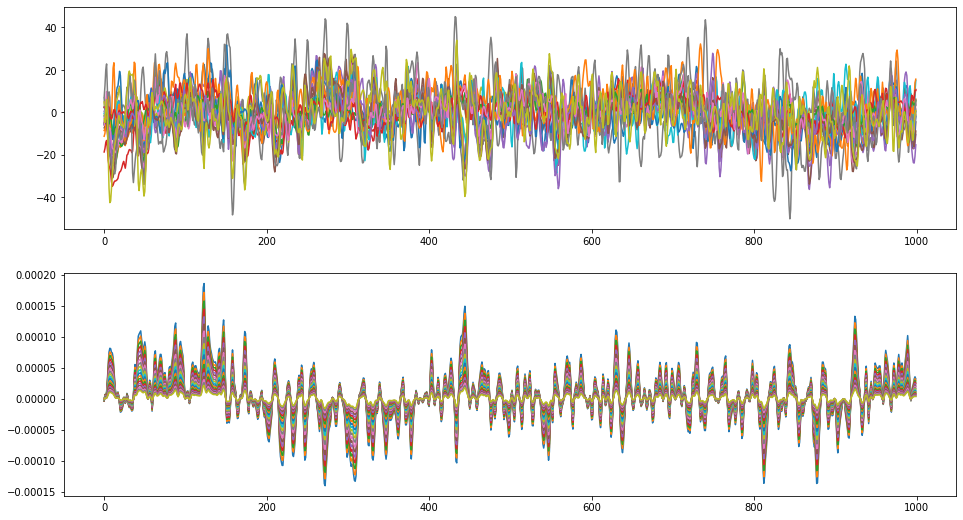

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 8))
target = 2000
print(label[target])
fig, axs = plt.subplots(2,1, figsize=(16,9))
axs[0].plot(data[target,:,:], label = 'raw')
axs[1].plot(filtered[target,:,:], label = 'filtered')
plt.show()
